# Predictor de Arqueotipos de Mazo de Hearthstone

**Autores:** Jorge Fatama Vera (Entrenamiento del Sistema de Predicción) y Sergio Cama Chávez (Servicio Web).<br>
**Universidad:** Pontificia Universidad Católica del Perú, Lima, Perú.<br>
**Curso:** *Curso de Capacitación en Deep Learning 2018-01*.<br>
**Con colaboración de:** Grupo de Inteligencia Artificial (IA-PUCP) & Sociedad de Apoyo para Informáticos (SAI-PUCP).

<img src="Images/hs-logo.png">

## Sustentación del Proyecto

En Kaggle se encontró un dataset llamado "*History of Hearthstone*", perteneciente al usuario *romainvincent*, el cual contiene, hasta su última actualización, alrededor de 3 mil cartas (en el archivo *refs.json*) y 300 mil mazos subidos a la conocida página *Hearthpwn* (en el archivo *data.csv*).

El objetivo del proyecto es resolver uno de los cuatro problemas planteados por *romainvincent* en la descripción de su dataset: predecir el arqueotipo de un mazo basado en las características de las cartas contenidas en éste. Para lograr este objetivo, se ha utilizado, como método de Aprendizaje de Máquina, el conocido *RandomForestClassifier*.

Como parte de un producto final, se implementó un servicio web que, habiendo recibido las treinta (30) cartas de un mazo, predice cuál es el arqueotipo al que más se ajusta. Esta parte del proyecto toma como ejemplo la mecánica de *HearthArena.com*, el cual es un servicio de ayuda de elección de cartas en el modo arena. Este servicio, el cual tiene una aplicación de escritorio que se conecta con el cliente de Hearthstone en el dispositivo donde se está jugando, una vez que se han escogido las 30 cartas, menciona algunas estadísticas del mazo de arena escogido, incluyendo el arqueotipo al que más se ajusta la combinación de cartas escogidas.

## Especificaciones del Proyecto

En primer lugar, en ambos archivos se encuentran datos irrelevantes:<br>
- **Con respecto a los mazos**, sólo utilizaremos los mazos pertenecientes al modo clasificatorio y los utilizados en torneos oficiales de *Hearthstone* del formato estándar. Además, hay parámetros que no necesitamos para la predición, como la fecha en la que se subieron a *Hearthpwn* o el seudónimo del usuario que subió el mazo.<br>
- **Con respecto a las cartas**, sólo utilizaremos las cartas coleccionables, las cuales son las únicas que se pueden utilizar en los mazos válidos. Además, hay parámetros que no necesitamos para la predición, como la descripción de la carta en la colección o la explicación de cómo obtener una copia de la carta en versión dorada.

Además, en una exploración rápida, se ha detectado que hay múltiples arqueotipos (alrededor de 50), los cuales complicarían la predición; esto se debe a que algunos arqueotipos comparten algunas características y porque el número de arqueotipos es excesivamente grande.<br>
Por esta razón, se ha decidido reducir el número de arqueotipos a cinco (en orden alfabético):
- **Aggro**:
- **Combo**:
- **Control**:
- **Midrange**:
- **Tempo**:

## Parte 1: Exploración, limpieza y pre-procesamiento de los datos

In [1]:
#Librerías utilizadas más frecuentemente
import pandas as pd
import numpy as np
#import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

## Parte 1.1: Extracción de los datos de las cartas

La información que respecta a las cartas del juego se encuentran en un objeto JSON llamado *cards.json* (en el dataset original se llama *refs.json*). Se procederá a cargar a memoria el objeto y a dar un vistazo a las características de sus parámetros.

In [2]:
#Leemos el JSON de las cartas
orig_cards = pd.read_json("Data/cards.json")

print(orig_cards.info())
orig_cards.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3117 entries, 0 to 3116
Data columns (total 32 columns):
artist                1527 non-null object
attack                1431 non-null float64
cardClass             3114 non-null object
classes               9 non-null object
collectible           1206 non-null float64
collectionText        12 non-null object
cost                  2420 non-null float64
dbfId                 3116 non-null float64
durability            71 non-null float64
elite                 353 non-null float64
entourage             58 non-null object
faction               72 non-null object
flavor                1193 non-null object
health                1539 non-null float64
hideStats             20 non-null float64
howToEarn             245 non-null object
howToEarnGolden       290 non-null object
id                    3117 non-null object
mechanics             1061 non-null object
multiClassGroup       9 non-null object
name                  3116 non-null object
o

,artist,attack,cardClass,classes,collectible,collectionText,cost,dbfId,durability,elite,...,playRequirements,playerClass,race,rarity,referencedTags,set,spellDamage,targetingArrowText,text,type
0,Jakub Kasper,4.0,NEUTRAL,NaN,1.0,NaN,4.0,2518.0,NaN,NaN,...,NaN,NEUTRAL,NaN,EPIC,[BATTLECRY],TGT,NaN,NaN,Whenever you play a card with <b>Battlecry</b>...,MINION
1,NaN,4.0,NEUTRAL,NaN,NaN,NaN,6.0,1769.0,NaN,1.0,...,NaN,NEUTRAL,NaN,LEGENDARY,NaN,CREDITS,NaN,NaN,<b>Battlecry:</b> Draw some cards. With a pen.,MINION
2,NaN,NaN,NEUTRAL,NaN,NaN,NaN,NaN,10081.0,NaN,NaN,...,NaN,NEUTRAL,NaN,NaN,NaN,TB,NaN,NaN,Attack and Health have been swapped by Deviate...,ENCHANTMENT
3,Mauricio Herrera,3.0,WARRIOR,NaN,1.0,NaN,3.0,40569.0,NaN,NaN,...,NaN,WARRIOR,NaN,RARE,NaN,GANGS,NaN,NaN,<b>Battlecry:</b> Give a random weapon in your...,MINION
4,Ittoku,2.0,NEUTRAL,NaN,1.0,NaN,4.0,1370.0,NaN,NaN,...,NaN,NEUTRAL,BEAST,FREE,NaN,CORE,NaN,NaN,NaN,MINION


El objeto JSON que almacena la información de las cartas contiene 32 parámetros, de los cuales la mayoría no nos servirán para cumplir nuestro objetivo. Luego de un análisis previo, se determinó que sólo mantendríamos 11 parámetros, los cuales algunos nos servirán para la predicción más adelante y los demás para cuestiones del análisis exploratorio de datos. A continuación se describirán los parámetros relevantes para la predicción.

### Parámetros relevantes (en orden alfabético)

- **collectible**: Bandera que indica si la carta es coleccionable. Es decir, si se puede conseguir en sobres de su respectiva expansión/aventura y/o comprar con polvo arcano.
- **id** (antes dbfId): Identificador de la carta que se usará para identificar su uso en los mazos.
- **playerClass**: Clase a la que corresponde la carta (puede ser neutral o cualquiera de las 9 clases disponibles).
- **race**: Raza del esbirro (ej: 'ELEMENTAL', 'MECH', 'MURLOC').
- **rarity**: Rareza de la carta: ['FREE','COMMON','RARE','EPIC','LEGENDARY']
- **type**: Tipo de carta: ['MINION','SPELL','WEAPON','HERO']. Para este proyecto sólo se usarán los tres primeros, puesto que la época de la última actualización del dataset aún no salían las cartas héroe.

In [3]:
#Primero, haremos una copia de nuestro dataframe
df_cards = orig_cards.copy()

#Mantenemos los parámetros relevantes
df_cards = df_cards[df_cards.columns[[2,4,6,7,20,25,31]]]

df_cards.rename(columns={'dbfId':'id', 'cardClass':'class'}, inplace=True)
df_cards['id'].fillna(0, inplace=True)
df_cards['id'] = df_cards['id'].astype(int)
df_cards['cost'].fillna(0, inplace=True)
df_cards['cost'] = df_cards['cost'].astype(int)
df_cards['collectible'].fillna(False, inplace=True)
df_cards['collectible'] = df_cards['collectible'].astype(bool)

#Actualizamos el índice de cada registro
df_cards.index = np.arange(0, len(df_cards))

print(df_cards.info())
df_cards.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3117 entries, 0 to 3116
Data columns (total 7 columns):
class          3114 non-null object
collectible    3117 non-null bool
cost           3117 non-null int32
id             3117 non-null int32
name           3116 non-null object
rarity         1598 non-null object
type           3116 non-null object
dtypes: bool(1), int32(2), object(4)
memory usage: 149.2+ KB
None


,class,collectible,cost,id,name,rarity,type
0,NEUTRAL,True,4,2518,Crowd Favorite,EPIC,MINION
1,NEUTRAL,False,6,1769,Ben Thompson,LEGENDARY,MINION
2,NEUTRAL,False,0,10081,Deviate Switch,NaN,ENCHANTMENT
3,WARRIOR,True,3,40569,Grimestreet Pawnbroker,RARE,MINION
4,NEUTRAL,True,4,1370,Oasis Snapjaw,FREE,MINION


## Parte 1.2: Extracción de los datos de los mazos

### Parámetros relevantes

In [4]:
#Leemos el CSV de las mazos
orig_decks = pd.read_csv('Data/decks.csv')

In [5]:
#Copiamos a un nuevo dataframe
df_decks = orig_decks.copy()

#Sólo nos interesan los mazos de formato normal (sólo Estándar y Salvaje)
df_decks = df_decks[(df_decks.deck_type == 'Ranked Deck') | (df_decks.deck_type == 'Tournament')]
df_decks = df_decks[df_decks.deck_format == 'S']

print(df_decks.info())
df_decks.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 103891 entries, 11 to 346230
Data columns (total 41 columns):
craft_cost        103891 non-null int64
date              103891 non-null object
deck_archetype    103891 non-null object
deck_class        103891 non-null object
deck_format       103891 non-null object
deck_id           103891 non-null int64
deck_set          103891 non-null object
deck_type         103891 non-null object
rating            103891 non-null int64
title             103890 non-null object
user              103891 non-null object
card_0            103891 non-null int64
card_1            103891 non-null int64
card_2            103891 non-null int64
card_3            103891 non-null int64
card_4            103891 non-null int64
card_5            103891 non-null int64
card_6            103891 non-null int64
card_7            103891 non-null int64
card_8            103891 non-null int64
card_9            103891 non-null int64
card_10           103891 non-null int64


,craft_cost,date,deck_archetype,deck_class,deck_format,deck_id,deck_set,deck_type,rating,title,...,card_20,card_21,card_22,card_23,card_24,card_25,card_26,card_27,card_28,card_29
11,0,2016-02-19,Unknown,Mage,S,432989,Explorers,Ranked Deck,2,Beginners Spelldamage Mage,...,662,662,672,672,906,906,1004,1004,1084,1084
19,5180,2016-02-19,Unknown,Rogue,S,432978,Explorers,Ranked Deck,1,Weazelbuster's Storm Rogue (Standard),...,1029,1064,1117,1117,1158,1158,268,556,2884,2884
31,6260,2016-02-19,Unknown,Druid,S,432954,Explorers,Ranked Deck,1,Ramp Druid,...,2598,2598,2736,2782,2782,2919,38113,38113,38319,38319
58,7980,2016-02-19,Fatigue Mage,Mage,S,432916,Explorers,Ranked Deck,1,K-DOG's Malygos Fatigue Mage: Wrecker of Contr...,...,1016,2262,2874,2875,2901,2901,2949,36111,39225,39840
98,1480,2016-02-19,Mill Rogue,Rogue,S,432849,Explorers,Ranked Deck,2,Mill Rogue Revived! (K-DOG),...,2291,2304,2304,2704,2883,2949,2951,38578,39313,39491


In [6]:
#Eliminamos los parámetros no relevantes
df_decks.drop(df_decks.columns[[1,3,4,5,6,7,8,9,10]], axis=1, inplace=True)

df_decks["craft_cost"] = df_decks["craft_cost"].astype(int)
for i in range(30):
    df_decks[df_decks.columns[i+2]] = df_decks[df_decks.columns[i+2]].astype(int)

#Actualizamos el índice de cada registro
df_decks.index = np.arange(0, len(df_decks))

print(df_decks.info())
df_decks.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 103891 entries, 0 to 103890
Data columns (total 32 columns):
craft_cost        103891 non-null int32
deck_archetype    103891 non-null object
card_0            103891 non-null int32
card_1            103891 non-null int32
card_2            103891 non-null int32
card_3            103891 non-null int32
card_4            103891 non-null int32
card_5            103891 non-null int32
card_6            103891 non-null int32
card_7            103891 non-null int32
card_8            103891 non-null int32
card_9            103891 non-null int32
card_10           103891 non-null int32
card_11           103891 non-null int32
card_12           103891 non-null int32
card_13           103891 non-null int32
card_14           103891 non-null int32
card_15           103891 non-null int32
card_16           103891 non-null int32
card_17           103891 non-null int32
card_18           103891 non-null int32
card_19           103891 non-null int32
card_20 

,craft_cost,deck_archetype,card_0,card_1,card_2,card_3,card_4,card_5,card_6,card_7,...,card_20,card_21,card_22,card_23,card_24,card_25,card_26,card_27,card_28,card_29
0,0,Unknown,77,77,90,90,175,175,315,315,...,662,662,672,672,906,906,1004,1004,1084,1084
1,5180,Unknown,180,180,365,365,459,459,461,559,...,1029,1064,1117,1117,1158,1158,268,556,2884,2884
2,6260,Unknown,64,64,95,137,137,254,254,420,...,2598,2598,2736,2782,2782,2919,38113,38113,38319,38319
3,7980,Fatigue Mage,138,138,172,172,395,395,436,447,...,1016,2262,2874,2875,2901,2901,2949,36111,39225,39840
4,1480,Mill Rogue,180,180,196,196,365,365,459,459,...,2291,2304,2304,2704,2883,2949,2951,38578,39313,39491


In [7]:
#Hay algunas cartas cuyo nombre coincide con algunas cartas de aventuras, que accidentalmente heredaron el ID de las no coleccio-
#nales, por lo que debemos buscarlas y reemplazarlas con sus verdaderos IDs

def replace_ambiguities():
    print('Processing',len(df_decks))
    for i in range(1000):
    #for i in range(len(df_decks)):
        deckRow = (df_decks.iloc[[i]].values.tolist())[0]
        #print(deckRow)
        #if i % 1000 == 0:
            #print('Indexing', i)
        for h in range(30):
            cardRow = (df_cards[df_cards.id == deckRow[h+2]].values.tolist())[0][1:6]
            #print(cardRow)
            if cardRow[0] != True:
                print('In', i+1,'we found',cardRow)
                listCoincidence = (df_cards[(df_cards.name == cardRow[3]) & (df_cards.collectible == True)].values.tolist())[0][3]
                #Reemplazar en todo el dataframe
                for k in range(30):
                    column = 'card_' + str(k)
                    df_decks[column] = df_decks[column].replace(cardRow[2], listCoincidence)
                deckRow = (df_decks.iloc[[i]].values.tolist())[0]
                print('Coincidence with',listCoincidence)

%time replace_ambiguities()

Processing 103891
In 3 we found [False, 0, 137, 'Wrath', nan]
Coincidence with 836
In 3 we found [False, 0, 38113, 'Raven Idol', 'COMMON']
Coincidence with 13335
In 3 we found [False, 5, 38319, 'Druid of the Claw', 'COMMON']
Coincidence with 692
In 8 we found [False, 10, 41609, 'Nefarian', 'LEGENDARY']
Coincidence with 2261
In 13 we found [False, 0, 1161, 'Starfall', nan]
Coincidence with 86
In 58 we found [False, 1, 40402, 'Evolve', 'RARE']
Coincidence with 38266
In 79 we found [False, 0, 468, 'Mark of Nature', nan]
Coincidence with 151
In 195 we found [False, 3, 2310, 'Druid of the Flame', 'COMMON']
Coincidence with 2292
In 259 we found [False, 0, 38653, 'Wisp', 'COMMON']
Coincidence with 179
In 481 we found [False, 0, 40341, 'Cleave', nan]
Coincidence with 940
Wall time: 18.5 s


In [8]:
#Archeotypes generalization and filter
df_decks['deck_archetype'] = df_decks['deck_archetype'].str.replace(r"Druid|Hunter|Mage|Paladin|Priest|Rogue|Shaman|Warrior|Warlock|Pally|adin|lock|Worgen", "").str.strip()
df_decks['deck_archetype'].value_counts()

Unknown          23274
Control           9751
Midrange          8277
Reno              7929
N'Zoth            6220
Dragon            5423
C'Thun            4008
Tempo             3710
Aggro             3451
Jade Lotus        3213
Miracle           2899
Ramp              2844
Yogg              2507
Zoo               2337
Pirate            1843
Murloc            1653
Beast             1514
Secrets           1486
Freeze            1375
Malygos           1229
Discard           1148
Hand               895
Patron             742
Fatigue            686
Resurrect          653
Secret             644
Mill               598
Token              578
Face               561
Totem              514
Demon              453
OTK                447
Shadow             439
Maly               170
Astral             155
Mur                 86
Silence             77
Randuin Wrynn       46
Edit                23
Water               23
Oil                  6
Mech                 4
Name: deck_archetype, dtype: int64

In [9]:
#Reemplazo muy rudimentario. Se mejorará después.
df_decks['deck_archetype'] = df_decks['deck_archetype'].replace('Reno','Control').replace('Demon','Control')
df_decks['deck_archetype'] = df_decks['deck_archetype'].replace('Dragon','Control').replace('Water','Combo')
df_decks['deck_archetype'] = df_decks['deck_archetype'].replace('Miracle','Combo').replace('OTK','Combo')
df_decks['deck_archetype'] = df_decks['deck_archetype'].replace('Ramp','Tempo').replace('Oil','Combo')
df_decks['deck_archetype'] = df_decks['deck_archetype'].replace('Yogg','Tempo').replace('Maly','Combo')
df_decks['deck_archetype'] = df_decks['deck_archetype'].replace('Zoo','Token').replace('Astral','Control')
df_decks['deck_archetype'] = df_decks['deck_archetype'].replace('Pirate','Aggro').replace('Mur','Aggro')
df_decks['deck_archetype'] = df_decks['deck_archetype'].replace('Murloc','Token').replace('Silence','Combo')
df_decks['deck_archetype'] = df_decks['deck_archetype'].replace('Beast','Midrange').replace('Randuin Wrynn','Combo')
df_decks['deck_archetype'] = df_decks['deck_archetype'].replace('Secrets','Tempo').replace('Totem','Token')
df_decks['deck_archetype'] = df_decks['deck_archetype'].replace('Freeze','Tempo').replace('Jade Lotus','Midrange')
df_decks['deck_archetype'] = df_decks['deck_archetype'].replace('Malygos','Combo').replace('Shadow','Control')
df_decks['deck_archetype'] = df_decks['deck_archetype'].replace('Discard','Midrange').replace('Edit','Unknown')
df_decks['deck_archetype'] = df_decks['deck_archetype'].replace('Hand','Control').replace('Mech','Tempo')
df_decks['deck_archetype'] = df_decks['deck_archetype'].replace('Fatigue','Control').replace('Mech','Tempo')
df_decks['deck_archetype'] = df_decks['deck_archetype'].replace('Resurrect','Control').replace('N\'Zoth','Control')
df_decks['deck_archetype'] = df_decks['deck_archetype'].replace('Secret','Tempo').replace('C\'Thun','Control')
df_decks['deck_archetype'] = df_decks['deck_archetype'].replace('Mill','Tempo').replace('Token','Midrange')
df_decks['deck_archetype'] = df_decks['deck_archetype'].replace('Face','Aggro').replace('Patron','Control')

df_decks.head()
df_decks['deck_archetype'].value_counts()

Control     37354
Unknown     23297
Midrange    19234
Tempo       13168
Aggro        5941
Combo        4897
Name: deck_archetype, dtype: int64

In [10]:
#Sólo nos interesan las cartas jugables (no las que aparecen en los créditos o las disponibles sólo en modo aventura)
df_cards = df_cards[df_cards.collectible == True]
df_cards.drop('collectible', axis=1, inplace=True) #Bandera que define si la carta es coleccionable. Se sobreentiende
df_cards.drop('name', axis=1, inplace=True)

In [11]:
df_cards.head()

,class,cost,id,rarity,type
0,NEUTRAL,4,2518,EPIC,MINION
3,WARRIOR,3,40569,RARE,MINION
4,NEUTRAL,4,1370,FREE,MINION
9,PRIEST,3,1363,FREE,SPELL
10,NEUTRAL,3,2579,COMMON,MINION


In [12]:
df_decks.head()

,craft_cost,deck_archetype,card_0,card_1,card_2,card_3,card_4,card_5,card_6,card_7,...,card_20,card_21,card_22,card_23,card_24,card_25,card_26,card_27,card_28,card_29
0,0,Unknown,77,77,90,90,175,175,315,315,...,662,662,672,672,906,906,1004,1004,1084,1084
1,5180,Unknown,180,180,365,365,459,459,461,559,...,1029,1064,1117,1117,1158,1158,268,556,2884,2884
2,6260,Unknown,64,64,95,836,836,254,254,420,...,2598,2598,2736,2782,2782,2919,13335,13335,692,692
3,7980,Control,138,138,172,172,395,395,436,447,...,1016,2262,2874,2875,2901,2901,2949,36111,39225,39840
4,1480,Tempo,180,180,196,196,365,365,459,459,...,2291,2304,2304,2704,2883,2949,2951,38578,39313,39491


In [13]:
#Copying the dataframes as a checkpoint
df2_cards = df_cards.copy()
df2_decks = (df_decks.copy())[0:1000]
#df2_decks = df_decks.copy()

In [14]:
def statics_deck(test):
    minion, spell, weapon, hero, avgDeck = 0,0,0,0,0
    #print(test)
    for h in range(30):
        #print(test[h+4])
        cardRow = (df2_cards[df2_cards.id == test[h+2]].values.tolist())[0]
        #print(cardRow)
        avgDeck += cardRow[1]
        if cardRow[4] == 'MINION':
            minion += 1
        elif cardRow[4] == 'SPELL':
            spell += 1
        elif cardRow[4] == 'WEAPON':
            weapon += 1
        elif cardRow[4] == 'HERO':
            hero += 1
    avgDeck = float(avgDeck)
    avgDeck /= 30
    return minion, spell, weapon, hero, avgDeck

In [15]:
arrM, arrS, arrW, arrH, arrAvg = [],[],[],[],[]

def general_statics():
    for i in range(1000):
    #for i in range(len(df2_decks)):
        #if i % 500 == 0:
        #    print('Indexing',i)
        #Set as integer
        prueba = (df2_decks.iloc[[i]].values.tolist())[0]
        #print(prueba)
        prueba[0] = int(prueba[0])
        contMin, contSpell, contWeap, contHero, avg = statics_deck(prueba)
        #print(contMin, contSpell, contWeap, contHero, avg)
        arrM.append(contMin)
        arrS.append(contSpell)
        arrW.append(contWeap)
        arrH.append(contHero)
        arrAvg.append(avg)

%time general_statics()

[0, 'Unknown', 77, 77, 90, 90, 175, 175, 315, 315, 395, 395, 447, 447, 555, 555, 564, 564, 587, 587, 635, 635, 662, 662, 672, 672, 906, 906, 1004, 1004, 1084, 1084]
[5180, 'Unknown', 180, 180, 365, 365, 459, 459, 461, 559, 573, 667, 667, 825, 825, 904, 904, 932, 932, 990, 990, 1029, 1029, 1064, 1117, 1117, 1158, 1158, 268, 556, 2884, 2884]
[6260, 'Unknown', 64, 64, 95, 836, 836, 254, 254, 420, 601, 601, 759, 759, 773, 1035, 1035, 1124, 1124, 1371, 1371, 1657, 2598, 2598, 2736, 2782, 2782, 2919, 13335, 13335, 692, 692]
[7980, 'Control', 138, 138, 172, 172, 395, 395, 436, 447, 447, 457, 457, 587, 587, 621, 621, 662, 662, 1004, 1004, 1016, 1016, 2262, 2874, 2875, 2901, 2901, 2949, 36111, 39225, 39840]
[1480, 'Tempo', 180, 180, 196, 196, 365, 365, 459, 459, 461, 461, 667, 825, 904, 904, 1016, 1016, 1117, 1158, 1158, 1651, 2291, 2304, 2304, 2704, 2883, 2949, 2951, 38578, 39313, 39491]
[8120, 'Combo', 180, 180, 306, 459, 461, 461, 559, 573, 667, 667, 749, 825, 825, 904, 904, 932, 932, 990, 9

[9720, 'Unknown', 75, 75, 338, 401, 401, 440, 546, 546, 596, 596, 759, 785, 785, 810, 1023, 1023, 1657, 1721, 2729, 2729, 2736, 38857, 38859, 38859, 38863, 38863, 38868, 38868, 38897, 38897]
[6920, 'Combo', 180, 180, 306, 459, 461, 461, 573, 573, 749, 825, 825, 904, 904, 932, 932, 990, 990, 1117, 1117, 1158, 1158, 268, 268, 1651, 1651, 2262, 2884, 2884, 38403, 38876]
[5700, 'Unknown', 64, 64, 95, 95, 836, 836, 254, 254, 601, 1657, 2262, 2792, 2792, 2949, 692, 692, 38488, 38547, 38547, 38621, 38621, 38718, 38795, 38857, 38859, 38859, 38882, 38882, 38958, 38958]
[3640, 'Unknown', 189, 189, 251, 251, 629, 766, 766, 767, 1008, 1171, 2513, 2513, 2610, 2610, 2615, 2620, 2890, 2890, 38263, 38263, 38265, 38267, 38267, 38722, 38724, 38724, 39008, 39008, 38266, 38266]
[5940, 'Unknown', 32, 189, 189, 238, 629, 629, 766, 825, 1008, 239, 239, 2513, 2513, 2610, 2610, 2620, 2890, 2890, 2901, 38263, 38265, 38265, 38267, 38267, 38270, 38722, 38724, 39008, 39008, 38266]
[7400, 'Unknown', 64, 64, 95, 95,

[5600, 'Unknown', 180, 180, 196, 365, 365, 630, 667, 667, 749, 825, 825, 904, 904, 1117, 1117, 1158, 1158, 2291, 2291, 2262, 2949, 38857, 38859, 38859, 38863, 38863, 38868, 38868, 38876, 38876]
[7680, 'Unknown', 138, 138, 172, 172, 192, 192, 251, 251, 315, 315, 457, 457, 555, 555, 581, 587, 587, 621, 621, 662, 662, 749, 1004, 1080, 1087, 1659, 2262, 2874, 2874, 38413]
[9440, 'Unknown', 9, 237, 237, 251, 251, 272, 279, 279, 308, 308, 436, 545, 545, 613, 613, 749, 912, 1362, 1362, 1363, 1650, 1650, 2262, 2582, 2582, 2736, 2951, 38433, 38433, 38439]
[2900, 'Unknown', 285, 22, 22, 338, 400, 400, 401, 401, 596, 636, 636, 654, 654, 785, 785, 1023, 1023, 1074, 1074, 1659, 1659, 2279, 2279, 38530, 38530, 38532, 38532, 38848, 38961, 38961]
[6680, 'Unknown', 189, 189, 505, 505, 629, 629, 749, 766, 766, 825, 825, 1008, 1721, 2289, 2289, 2290, 2290, 2513, 2513, 2514, 2610, 2610, 2620, 2949, 38267, 38267, 38270, 38722, 39008, 39008]
[6780, 'Unknown', 189, 189, 505, 505, 629, 629, 749, 766, 766, 825

[6000, 'Unknown', 64, 64, 836, 836, 254, 254, 1124, 1124, 38488, 38547, 38547, 38621, 38621, 38795, 38795, 38857, 38859, 38859, 38863, 38863, 38868, 38868, 38873, 38873, 38882, 38882, 38958, 38958, 39118, 39118]
[6840, 'Unknown', 251, 315, 315, 395, 405, 405, 555, 555, 564, 564, 614, 662, 662, 825, 825, 1004, 1080, 1084, 2275, 2275, 2546, 2571, 2571, 2261, 2683, 2874, 2874, 2875, 2875, 38505]
[8180, 'Tempo', 64, 64, 95, 836, 836, 254, 254, 734, 825, 825, 1035, 1124, 1124, 1721, 374, 2792, 2792, 2793, 38318, 692, 692, 38488, 38547, 38857, 38863, 38863, 38868, 38868, 38882, 38882]
[6120, 'Unknown', 147, 605, 605, 763, 763, 777, 891, 891, 950, 950, 993, 993, 1037, 1037, 1092, 1092, 1100, 1372, 1651, 1657, 1721, 2288, 2288, 2262, 2895, 2895, 38528, 38528, 38888, 38888]
[8700, 'Unknown', 180, 180, 306, 459, 459, 461, 573, 667, 667, 749, 825, 904, 904, 932, 990, 990, 1029, 1117, 1117, 1158, 1158, 1651, 2304, 2304, 2262, 2884, 38312, 38403, 38876, 38876]
[2420, 'Unknown', 250, 476, 476, 609, 

[11700, 'Control', 180, 180, 251, 306, 420, 461, 630, 630, 667, 749, 904, 904, 1117, 1158, 1158, 1651, 1651, 1721, 2291, 2884, 2884, 2891, 2891, 2949, 38403, 38496, 38876, 38876, 39026, 39026]
[4540, 'Control', 64, 64, 836, 836, 138, 254, 254, 891, 891, 1035, 1124, 1651, 2792, 2792, 2793, 38488, 38547, 38621, 38621, 38857, 38859, 38859, 38864, 38868, 38868, 38882, 38882, 38888, 38958, 38958]
[6800, 'Combo', 180, 180, 251, 251, 284, 306, 459, 461, 461, 749, 825, 825, 904, 904, 932, 932, 990, 990, 1158, 1158, 268, 268, 2262, 2884, 2884, 2951, 38403, 38578, 38578, 38876]
[11740, 'Control', 32, 189, 238, 629, 754, 766, 767, 825, 239, 1656, 1721, 374, 363, 2513, 2514, 2610, 2612, 2620, 2883, 2890, 2901, 2949, 2951, 38263, 38265, 38267, 38270, 38722, 39008, 38266]
[2220, 'Midrange', 189, 242, 242, 251, 830, 830, 352, 505, 513, 629, 629, 755, 766, 766, 1008, 239, 239, 2610, 2610, 2613, 2613, 2615, 2615, 2949, 38262, 38262, 39008, 39008, 38266, 38266]
[4400, 'Unknown', 75, 400, 400, 401, 401, 

[4360, 'Control', 237, 237, 272, 272, 613, 613, 841, 841, 1014, 1014, 1362, 1362, 1363, 1363, 1650, 1650, 38429, 38429, 38434, 38434, 38547, 38547, 38764, 38764, 38857, 38859, 38859, 38868, 39033, 39033]
[2700, 'Midrange', 64, 64, 95, 836, 836, 254, 254, 503, 742, 742, 825, 1029, 1029, 2292, 2292, 2780, 2782, 2782, 2783, 2783, 2792, 2792, 2922, 2922, 13335, 13335, 38318, 692, 38337, 38337]
[9720, 'Control', 75, 401, 401, 546, 546, 596, 785, 785, 810, 1023, 1074, 2729, 2729, 2736, 2949, 38475, 38488, 38547, 38547, 38795, 38857, 38859, 38859, 38863, 38863, 38864, 38897, 38897, 38958, 38958]
[10760, 'Control', 75, 285, 338, 400, 401, 538, 546, 581, 596, 785, 810, 1023, 1074, 1657, 1659, 1721, 2296, 2729, 2736, 2883, 38488, 38547, 38738, 38795, 38857, 38859, 38863, 38868, 38918, 38958]
[7060, 'Control', 476, 476, 581, 594, 609, 609, 763, 825, 825, 847, 847, 890, 756, 756, 1167, 1167, 1659, 1659, 2299, 2299, 2408, 2408, 2409, 2409, 2569, 2569, 2682, 2949, 38740, 38740]
[9540, 'Midrange', 13

[8720, 'Control', 180, 180, 459, 459, 630, 667, 667, 749, 825, 825, 904, 904, 1158, 1158, 2262, 2884, 2949, 38391, 38391, 38403, 38488, 38547, 38547, 38857, 38859, 38859, 38861, 38863, 38863, 38876]
[8980, 'Tempo', 138, 138, 172, 172, 192, 192, 315, 315, 430, 457, 457, 555, 555, 581, 587, 587, 621, 621, 662, 662, 748, 749, 1004, 1080, 1087, 1659, 1659, 2262, 2874, 38475]
[17320, 'Control', 75, 138, 304, 338, 401, 440, 546, 581, 596, 734, 754, 759, 785, 810, 912, 1023, 1186, 1657, 1721, 2296, 336, 374, 2683, 2704, 2729, 2736, 2883, 2894, 2951, 39041]
[10120, 'Control', 290, 296, 296, 311, 420, 437, 437, 141, 1003, 1003, 1261, 1261, 1657, 1721, 2260, 2260, 374, 2502, 2502, 2635, 2635, 2892, 2892, 38496, 38727, 38734, 38734, 38875, 38875, 38910]
[5360, 'Tempo', 138, 138, 172, 172, 192, 192, 251, 251, 284, 284, 315, 315, 430, 457, 457, 555, 555, 581, 587, 587, 621, 621, 662, 662, 1004, 1080, 1659, 1659, 2262, 2874]
[4880, 'Midrange', 32, 189, 189, 238, 238, 629, 766, 766, 825, 825, 2289, 2

[4240, 'Control', 28, 22, 22, 338, 400, 400, 401, 401, 596, 596, 636, 636, 654, 654, 785, 785, 1074, 1074, 1656, 1659, 1659, 2279, 2279, 2262, 2948, 38530, 38738, 38738, 38918, 38918]
[10980, 'Control', 138, 138, 251, 420, 476, 476, 594, 778, 778, 847, 847, 890, 756, 756, 1014, 1014, 1167, 1167, 1371, 1721, 2655, 2655, 2889, 2889, 38496, 38666, 38666, 38758, 38784, 38784]
[1680, 'Unknown', 28, 28, 1007, 1007, 242, 304, 304, 401, 401, 511, 511, 538, 724, 724, 804, 804, 810, 878, 878, 999, 999, 1016, 1016, 2729, 2729, 2948, 38914, 38914, 38920, 38920]
[8600, 'Control', 147, 147, 605, 605, 754, 763, 763, 777, 891, 891, 950, 993, 993, 1037, 1037, 1092, 1092, 1100, 1100, 1651, 1651, 1721, 2262, 2704, 2704, 2949, 9107, 9107, 38464, 38944]
[3860, 'Control', 48, 48, 147, 211, 290, 763, 846, 846, 1073, 1090, 1657, 2288, 2288, 2895, 2895, 2949, 38454, 38488, 38547, 38547, 38770, 38774, 38774, 38795, 38857, 38859, 38859, 38863, 38868, 38868]
[11300, 'Unknown', 138, 250, 476, 476, 594, 734, 754, 8

[6440, 'Tempo', 315, 315, 395, 395, 405, 405, 555, 555, 564, 614, 614, 662, 662, 825, 825, 1004, 1080, 1084, 2275, 2275, 2262, 374, 2572, 2572, 2874, 2875, 38409, 38413, 38505, 38725]
[6140, 'Tempo', 64, 64, 95, 836, 836, 254, 254, 825, 825, 1124, 1124, 1721, 2262, 2782, 2782, 2792, 2792, 692, 692, 38488, 38547, 38547, 38718, 38718, 38857, 38863, 38863, 38868, 38882, 38882]
[4440, 'Control', 189, 189, 629, 763, 763, 766, 766, 825, 825, 1008, 1008, 1171, 2513, 2513, 2610, 2610, 2620, 2890, 2890, 38265, 38265, 38267, 38267, 38270, 38722, 38724, 38724, 39008, 39008, 38266]
[3120, 'Control', 180, 180, 282, 282, 345, 345, 461, 461, 630, 667, 667, 825, 825, 904, 904, 1117, 1117, 38488, 38547, 38547, 38795, 38795, 38857, 38859, 38859, 38861, 38863, 38863, 38868, 38868]
[2380, 'Control', 365, 365, 1651, 2304, 2304, 2262, 2280, 2949, 38391, 38393, 38547, 38547, 38795, 38795, 38857, 38859, 38859, 38861, 38861, 38863, 38863, 38864, 38864, 38868, 38868, 38888, 38888, 38958, 39118, 39118]
[9000, 'C

[3720, 'Aggro', 211, 211, 242, 242, 251, 251, 289, 584, 584, 679, 679, 755, 943, 943, 847, 847, 994, 994, 2274, 2274, 2503, 2736, 2889, 2889, 38538, 38538, 38781, 38781, 38911, 38911]
[8480, 'Tempo', 36, 64, 64, 95, 836, 836, 254, 254, 601, 825, 825, 1035, 1035, 1124, 1124, 1721, 2262, 374, 2782, 2782, 2792, 38318, 692, 692, 38547, 38547, 38718, 38718, 38863, 38863]
[8420, 'Tempo', 36, 64, 64, 95, 836, 836, 254, 254, 754, 825, 825, 1035, 1035, 1124, 1124, 1721, 2262, 374, 2782, 2782, 2792, 38318, 692, 692, 38547, 38547, 38718, 38718, 38863, 38863]
[4280, 'Control', 282, 345, 459, 459, 461, 461, 531, 630, 635, 635, 904, 904, 990, 1117, 1117, 2291, 2304, 2884, 2884, 2891, 38403, 38567, 38567, 38578, 38578, 38876, 38876, 38888, 39026, 39026]
[5920, 'Control', 32, 189, 189, 505, 505, 629, 766, 766, 767, 239, 2513, 2513, 2610, 2610, 2612, 2620, 2890, 2901, 2901, 38265, 38265, 38267, 38267, 38270, 38722, 38724, 39008, 39008, 38266, 38266]
[15040, 'Control', 75, 75, 401, 401, 785, 785, 1023, 

[80, 'Unknown', 64, 64, 90, 90, 836, 205, 205, 213, 216, 216, 254, 254, 308, 308, 151, 608, 608, 635, 635, 672, 823, 823, 906, 906, 1050, 1124, 1124, 1182, 1182, 1686]
[6200, 'Control', 64, 64, 95, 836, 254, 254, 581, 1035, 1035, 1124, 1124, 1657, 2782, 2949, 38488, 38547, 38547, 38621, 38621, 38718, 38718, 38857, 38859, 38859, 38868, 38868, 38882, 38882, 38958, 38958]
[7860, 'Control', 180, 251, 251, 306, 365, 365, 461, 667, 749, 825, 825, 904, 904, 1117, 1651, 1721, 2291, 2262, 2724, 2884, 2884, 2891, 2891, 2948, 2949, 2951, 38578, 38578, 38876, 38876]
[12300, 'Unknown', 75, 285, 401, 546, 581, 596, 635, 785, 825, 834, 1023, 1037, 1074, 1186, 1657, 1659, 2296, 2408, 2409, 2569, 2682, 2729, 2736, 2758, 2883, 2894, 38792, 38848, 38914, 38943]
[3900, 'Unknown', 296, 296, 437, 437, 455, 825, 896, 1003, 1073, 1073, 1093, 1243, 1243, 1261, 1662, 2260, 2502, 2502, 2510, 2510, 2552, 2635, 2635, 2683, 2892, 2892, 2918, 2918, 2919, 2949]
[7920, 'Unknown', 30, 30, 237, 237, 545, 545, 581, 613, 

[2940, 'Control', 64, 64, 836, 836, 254, 254, 763, 825, 825, 1124, 1124, 692, 692, 38488, 38547, 38547, 38621, 38621, 38718, 38718, 38857, 38859, 38859, 38863, 38863, 38864, 38868, 38868, 38882, 38882]
[3460, 'Unknown', 28, 28, 285, 285, 304, 304, 401, 401, 1026, 538, 538, 680, 680, 724, 724, 785, 785, 804, 804, 999, 999, 1074, 1074, 1659, 1659, 2757, 38914, 38914, 38920, 38920]
[14120, 'Control', 138, 138, 420, 476, 476, 594, 754, 847, 847, 854, 854, 890, 912, 756, 756, 1014, 1014, 1167, 1167, 1371, 1371, 1659, 1659, 1721, 2274, 38496, 38666, 38666, 38758, 38944]
[3980, 'Midrange', 32, 189, 189, 238, 238, 352, 513, 629, 629, 757, 766, 766, 1008, 1008, 239, 239, 2513, 2513, 2580, 2610, 2610, 2890, 2890, 38263, 38265, 38265, 38267, 38267, 39008, 39008]
[13680, 'Control', 75, 75, 285, 338, 401, 401, 546, 546, 581, 596, 596, 785, 785, 1023, 1023, 1074, 1186, 1657, 1659, 1659, 1721, 2296, 2262, 336, 374, 2729, 2729, 2736, 2951, 38738]
[1740, 'Midrange', 238, 238, 352, 513, 629, 757, 757, 7

[3120, 'Control', 296, 415, 437, 519, 585, 754, 811, 825, 141, 1093, 1243, 1261, 1651, 1662, 2260, 2552, 2634, 2635, 2638, 2641, 2752, 2883, 2901, 2919, 2949, 3001, 38377, 38528, 38584, 38727]
[6040, 'Control', 48, 138, 147, 763, 777, 859, 891, 906, 950, 846, 993, 1037, 1092, 1100, 1651, 1657, 1721, 2288, 2301, 2262, 2704, 2883, 2895, 2949, 38454, 38534, 38569, 38774, 38888, 39453]
[1880, 'Aggro', 242, 242, 476, 679, 679, 755, 757, 757, 943, 943, 847, 847, 756, 1022, 1022, 1167, 2490, 2490, 2717, 2889, 2889, 38538, 38538, 38740, 38740, 38745, 38745, 38843, 38911, 38911]
[6640, 'Control', 180, 345, 459, 461, 630, 667, 749, 825, 904, 932, 1029, 1117, 1158, 1657, 1721, 2262, 2770, 2883, 2901, 38391, 38393, 38395, 38403, 38547, 38857, 38859, 38863, 38864, 38868, 38888]
[4360, 'Control', 75, 400, 401, 401, 546, 546, 596, 596, 785, 785, 1023, 1023, 1074, 1074, 1659, 1659, 2949, 38488, 38530, 38547, 38547, 38795, 38857, 38864, 38868, 38868, 38897, 38897, 38958, 39118]
[6120, 'Midrange', 32, 1

[4400, 'Control', 48, 48, 147, 242, 242, 348, 763, 763, 846, 846, 1073, 1073, 2288, 2288, 2895, 2895, 2949, 38452, 38452, 38454, 38488, 38547, 38547, 38774, 38774, 38857, 38859, 38859, 38898, 38944]
[4880, 'Control', 64, 64, 95, 836, 836, 254, 254, 1035, 1124, 1124, 2949, 692, 692, 38488, 38547, 38547, 38621, 38621, 38718, 38718, 38795, 38857, 38859, 38859, 38863, 38863, 38868, 38868, 38882, 38882]
[5060, 'Control', 9, 237, 272, 613, 613, 635, 635, 841, 841, 1014, 1014, 1109, 1109, 1362, 1362, 1363, 1363, 1650, 1650, 2262, 2582, 2582, 2736, 2878, 2878, 2951, 3015, 3015, 38439, 38439]
[7840, 'Tempo', 315, 315, 395, 395, 405, 405, 555, 555, 564, 564, 614, 614, 662, 662, 825, 825, 1080, 1084, 1656, 2275, 2275, 2546, 2572, 2572, 2875, 38505, 38725, 38725, 38900, 38900]
[3680, 'Tempo', 437, 437, 141, 141, 1093, 1093, 1243, 1243, 2260, 2260, 2483, 2483, 2484, 2575, 2575, 2635, 2635, 2638, 2638, 2641, 2641, 2261, 2948, 3001, 3001, 38377, 38377, 38505, 38727, 38727]
[11380, 'Control', 238, 505

[7900, 'Control', 180, 180, 251, 251, 345, 345, 825, 904, 904, 1117, 1117, 1651, 1651, 1721, 2586, 2884, 2884, 2891, 2891, 38393, 38393, 38403, 38496, 38578, 38578, 38784, 38784, 38876, 39026, 39026]
[4660, 'Tempo', 64, 64, 95, 836, 836, 254, 254, 742, 825, 825, 1124, 1124, 1657, 2782, 2782, 2792, 2922, 2922, 2949, 692, 692, 38488, 38547, 38547, 38857, 38863, 38863, 38882, 38882, 38944]
[960, 'Midrange', 48, 48, 242, 242, 348, 348, 631, 763, 846, 846, 985, 985, 1090, 1090, 1092, 1092, 2278, 2278, 2288, 2288, 2895, 2895, 2949, 13334, 38452, 38452, 38454, 38454, 38774, 38774]
[5140, 'Midrange', 64, 836, 138, 242, 254, 290, 415, 503, 601, 734, 754, 757, 763, 825, 891, 1035, 1073, 1124, 1651, 1721, 2292, 374, 2782, 2792, 2883, 2901, 2922, 13335, 692, 38334]
[8120, 'Unknown', 251, 365, 365, 415, 749, 904, 904, 990, 2262, 2884, 2884, 2949, 38393, 38393, 38488, 38547, 38547, 38857, 38859, 38859, 38861, 38861, 38863, 38863, 38868, 38868, 38876, 38876, 38958, 38958]
[8840, 'Unknown', 420, 437, 

[5540, 'Tempo', 138, 138, 315, 315, 405, 405, 457, 555, 555, 564, 564, 587, 587, 614, 614, 662, 662, 1004, 1004, 1080, 1084, 1084, 2275, 2275, 38407, 38407, 38413, 38418, 38418, 38505]
[8060, 'Control', 180, 180, 365, 459, 459, 461, 461, 667, 667, 904, 904, 932, 932, 1064, 1117, 1117, 1158, 1158, 2884, 2884, 38403, 38488, 38547, 38547, 38857, 38861, 38861, 38863, 38958, 38958]
[5160, 'Midrange', 48, 48, 211, 211, 242, 242, 559, 763, 763, 846, 846, 985, 985, 1073, 1073, 2288, 2288, 2895, 2895, 38452, 38452, 38454, 38454, 38538, 38538, 38774, 38774, 38797, 38797, 38944]
[3520, 'Midrange', 64, 64, 233, 254, 254, 503, 503, 742, 742, 2292, 2292, 2782, 2782, 2783, 2783, 2786, 2786, 2788, 2788, 2792, 2792, 38318, 692, 692, 38337, 38337, 38340, 38340, 38916, 38916]
[3420, 'Midrange', 296, 296, 437, 437, 754, 141, 141, 1003, 1003, 1073, 1243, 1261, 1261, 2260, 2260, 2502, 2552, 2580, 2580, 2635, 2635, 2892, 2892, 38584, 38584, 38727, 38727, 38734, 38734, 38910]
[820, 'Tempo', 315, 395, 395, 405

[6200, 'Control', 138, 138, 237, 237, 272, 272, 279, 279, 613, 613, 797, 825, 841, 1362, 1362, 1363, 1363, 1367, 1367, 1650, 1650, 2582, 2582, 2736, 2999, 2999, 38434, 38439, 38505, 38764]
[7900, 'Aggro', 476, 476, 594, 757, 757, 763, 763, 943, 943, 847, 847, 890, 756, 1022, 1022, 1167, 1167, 1721, 2490, 2490, 2580, 2580, 2736, 2889, 2889, 38526, 38526, 38745, 38745, 38758]
[3960, 'Tempo', 36, 64, 64, 90, 90, 95, 205, 254, 254, 151, 151, 503, 503, 757, 757, 791, 906, 906, 1014, 1124, 1124, 2949, 38318, 38857, 38859, 38859, 38863, 38868, 38868, 39118]
[15080, 'Control', 138, 476, 594, 847, 854, 890, 906, 756, 1014, 1167, 1371, 1721, 2262, 374, 2736, 2883, 2889, 2951, 38488, 38496, 38547, 38666, 38758, 38795, 38857, 38859, 38863, 38868, 38958, 39119]
[2320, 'Midrange', 64, 64, 68, 68, 836, 836, 254, 254, 503, 503, 742, 742, 2292, 2780, 2780, 2783, 2783, 2792, 2901, 2901, 2918, 2918, 2922, 2922, 2948, 38318, 692, 692, 38337, 38337]
[1220, 'Unknown', 28, 28, 304, 304, 400, 400, 401, 401, 5

[2660, 'Midrange', 453, 475, 475, 510, 70, 70, 679, 679, 739, 739, 847, 847, 976, 976, 1016, 1016, 1063, 1063, 2655, 2655, 2889, 2898, 2898, 2948, 38227, 38227, 38538, 38538, 38911, 38911]
[5980, 'Midrange', 138, 138, 476, 476, 594, 679, 739, 739, 847, 847, 854, 890, 906, 756, 756, 1014, 1014, 1063, 1063, 1167, 1167, 1659, 1659, 2654, 2654, 2889, 2898, 2898, 38666, 38666]
[8600, 'Control', 272, 272, 613, 613, 825, 825, 841, 841, 1186, 1363, 1367, 1650, 1721, 2286, 2408, 2408, 2409, 2409, 2569, 2569, 2596, 2596, 2878, 2878, 3015, 3015, 38496, 38943, 39034, 39034]
[6700, 'Control', 476, 476, 825, 825, 847, 847, 890, 756, 756, 1014, 1014, 1167, 1167, 1186, 2258, 2299, 2299, 2408, 2408, 2409, 2409, 2504, 2504, 2569, 2569, 2261, 2682, 2720, 2889, 2889]
[7500, 'Control', 138, 147, 754, 763, 777, 859, 906, 914, 950, 1037, 1092, 1100, 1657, 1721, 2288, 2301, 2262, 2883, 2895, 2949, 38488, 38547, 38857, 38859, 38863, 38868, 38888, 38898, 38958, 39041]
[1020, 'Tempo', 77, 77, 315, 315, 405, 405,

[3360, 'Tempo', 77, 315, 315, 395, 395, 405, 405, 555, 555, 564, 564, 614, 614, 662, 662, 825, 825, 1004, 1084, 1084, 2275, 2275, 2572, 2572, 2874, 2875, 38418, 38505, 38900, 38900]
[800, 'Combo', 28, 28, 251, 251, 285, 285, 308, 308, 22, 22, 400, 400, 401, 401, 762, 762, 785, 785, 1074, 1074, 1155, 1155, 1659, 1659, 344, 344, 38530, 38530, 38738, 38738]
[8480, 'Control', 138, 138, 147, 147, 420, 763, 763, 777, 778, 778, 891, 891, 950, 950, 1037, 1037, 1092, 1092, 1100, 1100, 1371, 1371, 1721, 2288, 2288, 2301, 2301, 2895, 2895, 38496]
[13620, 'Control', 75, 75, 338, 401, 401, 546, 546, 581, 596, 785, 785, 810, 912, 1023, 1023, 1074, 1074, 1656, 1721, 2296, 2296, 336, 2729, 2729, 2736, 2951, 38530, 38530, 38738, 38738]
[9840, 'Unknown', 476, 476, 594, 763, 847, 847, 890, 912, 756, 1073, 1073, 1167, 1167, 1721, 2504, 2580, 2580, 2727, 2736, 2889, 2889, 38526, 38526, 38740, 38740, 38745, 38863, 38863, 38911, 38911]
[3620, 'Midrange', 296, 296, 437, 437, 519, 1003, 1003, 1073, 1093, 1243,

[2480, 'Midrange', 189, 189, 238, 308, 352, 629, 763, 766, 864, 1008, 239, 239, 1651, 2513, 2513, 2514, 2610, 2610, 2890, 2890, 2949, 38265, 38267, 38267, 38270, 38538, 39008, 39008, 38266, 38266]
[4640, 'Tempo', 315, 315, 395, 395, 405, 405, 555, 555, 564, 564, 614, 614, 662, 662, 825, 825, 1080, 2275, 2275, 2571, 2571, 2572, 2572, 2874, 2874, 2875, 2875, 38505, 38900, 38900]
[9060, 'Control', 180, 180, 306, 365, 904, 904, 1117, 1117, 1651, 1651, 1721, 2291, 2770, 2948, 2949, 38403, 38488, 38547, 38547, 38578, 38578, 38857, 38861, 38861, 38863, 38863, 38876, 38876, 39026, 39026]
[3600, 'Control', 272, 613, 613, 825, 825, 841, 841, 1186, 1363, 1363, 1367, 1367, 1650, 1650, 2286, 2286, 2408, 2408, 2409, 2409, 2569, 2569, 2596, 2596, 2261, 2878, 2878, 2949, 3015, 38832]
[800, 'Tempo', 77, 77, 195, 315, 315, 405, 405, 555, 555, 564, 564, 614, 662, 662, 734, 1004, 1004, 2901, 38412, 38725, 38725, 38857, 38859, 38859, 38863, 38863, 38868, 38868, 38900, 38900]
[1160, 'Midrange', 48, 48, 242,

[10800, 'Control', 420, 461, 461, 667, 667, 1721, 2262, 374, 2891, 2891, 2949, 38393, 38393, 38488, 38496, 38547, 38547, 38578, 38857, 38861, 38861, 38863, 38863, 38876, 38888, 38888, 38958, 38958, 39026, 39026]
[8780, 'Control', 138, 138, 237, 237, 272, 912, 1362, 1362, 1363, 1363, 1367, 1367, 1721, 2582, 2582, 2736, 2878, 2878, 2999, 2999, 3015, 3015, 38426, 38434, 38496, 38528, 38764, 38764, 39034, 39034]
[5020, 'Midrange', 238, 238, 352, 513, 513, 629, 766, 766, 1008, 1008, 239, 363, 2513, 2513, 2610, 2610, 2890, 38267, 38267, 38488, 38517, 38517, 38859, 38859, 38863, 38863, 39008, 39008, 38266, 38266]
[5160, 'Midrange', 36, 836, 836, 254, 254, 503, 503, 742, 742, 778, 778, 811, 811, 912, 1029, 1029, 2792, 2792, 2922, 2922, 38538, 38538, 38655, 38655, 38718, 38718, 38797, 38797, 38916, 38916]
[4740, 'Tempo', 77, 113, 315, 315, 395, 395, 405, 405, 555, 555, 564, 614, 614, 662, 662, 825, 825, 1004, 1084, 2275, 2275, 374, 2572, 2875, 38418, 38505, 38725, 38725, 38900, 38900]
[3700, 'M

In [16]:
print(len(arrAvg), len(arrM), len(arrS), len(arrW), len(arrH))

consecutive = []
for i in range(30):
    consecutive.append(i+2)

df2_decks.drop(df2_decks.columns[consecutive], axis=1, inplace=True)

df2_decks['avg_mana'] = arrAvg
df2_decks['nminions'] = arrM
df2_decks['nspells'] = arrS
df2_decks['nweapons'] = arrW
df2_decks['nheroes'] = arrH

print(df2_decks.info())
df2_decks.head()

1000 1000 1000 1000 1000
<class 'pandas.core.frame.DataFrame'>
Int64Index: 1000 entries, 0 to 999
Data columns (total 7 columns):
craft_cost        1000 non-null int32
deck_archetype    1000 non-null object
avg_mana          1000 non-null float64
nminions          1000 non-null int64
nspells           1000 non-null int64
nweapons          1000 non-null int64
nheroes           1000 non-null int64
dtypes: float64(1), int32(1), int64(4), object(1)
memory usage: 58.6+ KB
None


,craft_cost,deck_archetype,avg_mana,nminions,nspells,nweapons,nheroes
0,0,Unknown,3.066667,12,18,0,0
1,5180,Unknown,2.600000,12,18,0,0
2,6260,Unknown,3.900000,18,12,0,0
3,7980,Control,3.733333,15,15,0,0
4,1480,Tempo,2.600000,12,18,0,0


In [20]:
#Checkpoint approved
df_cards = df2_cards.copy()
df_decks = df2_decks.copy()
#2nd. Checkpoint

### Discretización

In [21]:
#Ya no necesitamos los id de las cartas
df_decks.drop("nheroes", axis=1, inplace=True) #En 2016 no existían cartas héroe
df_decks.drop("nweapons", axis=1, inplace=True) #Hay muchos mazos que no tienen armas

df_decks = df_decks[['craft_cost','avg_mana','nminions','nspells','deck_archetype']]

In [22]:
#Ahora, separaremos los etiquetados

willLabel = df_decks[df_decks.deck_archetype == 'Unknown']
df_decks = df_decks[df_decks.deck_archetype != 'Unknown']

print(f'Non-labeled shape: {willLabel.shape}')
print(f'Labeled shape    : {df_decks.shape}')

Non-labeled shape: (314, 5)
Labeled shape    : (686, 5)


In [23]:
#Lo mismo con arqueotipos
colec_archetype = df_decks[['deck_archetype']].drop_duplicates().sort_values('deck_archetype')
colec_archetype.index = np.arange(0, 5)

cat_dict_arch = colec_archetype.to_dict()

cat_dict_arch

{'deck_archetype': {0: 'Aggro',
  1: 'Combo',
  2: 'Control',
  3: 'Midrange',
  4: 'Tempo'}}

In [24]:
def transform_categories(df, cat_dict, banned):
    #Transformando las clases en categorías
    for n,col in df.items():
        if not pd.api.types.is_numeric_dtype(col) and n != banned:
            # Transforma la variable a tipo category
            df[n] = col.astype('category')

            # Actualiza cat_dict
            cat_dict[n] = {i:e for i,e in enumerate(df[n].cat.categories)}

    for n,col in df.items():
        if pd.api.types.is_categorical_dtype(col):
            df[n] = col.cat.codes

In [26]:
transform_categories(df_decks, cat_dict_arch, 'deck_class')
df_decks.head(7)

,craft_cost,avg_mana,nminions,nspells,deck_archetype
3,7980,3.733333,15,15,2
4,1480,2.600000,12,18,4
5,8120,2.566667,13,17,1
31,16220,4.033333,19,10,3
55,6920,2.633333,15,15,1
62,4400,3.200000,16,14,1
76,4040,3.200000,18,11,2


### Entrenamiento (Random Forest)

In [28]:
from sklearn.model_selection import train_test_split

x = df_decks.drop('deck_archetype', axis=1)
y = df_decks['deck_archetype']

x_train, x_val, y_train, y_val = train_test_split(x, y, test_size=0.2, random_state=42)
print(f'Train shape     : {x_train.shape}')
print(f'Validation shape: {x_val.shape}')

Train shape     : (548, 4)
Validation shape: (138, 4)


In [29]:
from sklearn.ensemble import RandomForestClassifier

m = RandomForestClassifier(n_estimators=150, n_jobs=-1, oob_score=True, min_samples_split=5)
m.fit(x_train, y_train)

C:\Users\labtel\Anaconda2\envs\ml\lib\site-packages\sklearn\ensemble\weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=5,
            min_weight_fraction_leaf=0.0, n_estimators=150, n_jobs=-1,
            oob_score=True, random_state=None, verbose=0, warm_start=False)

In [30]:
def score():
    print(f'Scores:')
    print(f'Train      = {m.score(x_train, y_train):.4}')
    print(f'Validation = {m.score(x_val, y_val):.4}')
    if hasattr(m, 'oob_score_'): print(f'OOB        = {m.oob_score_:.4}')
    
score()    

Scores:
Train      = 0.9471
Validation = 0.7174
OOB        = 0.6934


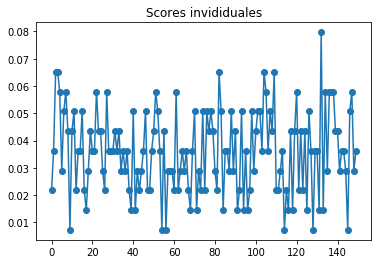

In [31]:
from sklearn.metrics import accuracy_score

preds = np.stack([t.predict(x_val) for t in m.estimators_])
accs = [accuracy_score(y_val==2, p) for p in preds]
plt.plot(accs, '-o')
plt.title('Scores invididuales');

In [32]:
# Usemos los árboles para obtener una predicción con una estimación de confianza.
sample = x_val.sample(1)

pred = np.stack([t.predict(sample) for t in m.estimators_])

pred.mean(), pred.mean() > 0.5, pred.std()

(2.0, True, 0.0)

### Predicción

Fuente: https://chrisalbon.com/machine_learning/trees_and_forests/random_forest_classifier_example/

In [33]:
features = df_decks.columns[:4]

features

Index(['craft_cost', 'avg_mana', 'nminions', 'nspells'], dtype='object')

In [34]:
m.predict_proba(x_train[features])[0:10]

array([[0.        , 0.        , 0.96942857, 0.00857143, 0.022     ],
       [0.        , 0.        , 0.82564021, 0.14965608, 0.0247037 ],
       [0.        , 0.        , 0.64554762, 0.30361111, 0.05084127],
       [0.011     , 0.0281746 , 0.17955291, 0.59182011, 0.18945238],
       [0.06593651, 0.00111111, 0.52039683, 0.36587302, 0.04668254],
       [0.7737963 , 0.01034921, 0.04342593, 0.11293915, 0.05948942],
       [0.        , 0.        , 0.97366667, 0.02      , 0.00633333],
       [0.        , 0.        , 0.99238095, 0.00285714, 0.0047619 ],
       [0.02812698, 0.        , 0.51711905, 0.41395503, 0.04079894],
       [0.00333333, 0.        , 0.37075926, 0.24806878, 0.37783862]])

In [35]:
#Guardado de predición en disco
import pickle

pkl_prediction = "pickle_predict.pkl"  
with open(pkl_prediction, 'wb') as file:  
    pickle.dump(m, file)

Ahora trabajaremos con la data no clasificada

In [36]:
willLabel.head(8)

,craft_cost,avg_mana,nminions,nspells,deck_archetype
0,0,3.066667,12,18,Unknown
1,5180,2.600000,12,18,Unknown
2,6260,3.900000,18,12,Unknown
6,960,2.000000,14,16,Unknown
7,8640,5.000000,25,4,Unknown
8,7920,3.733333,20,10,Unknown
9,7520,4.533333,18,10,Unknown
10,10240,5.066667,22,8,Unknown


In [37]:
archetype_predicted = m.predict(willLabel[features])
archetype_predicted[0:10]

array([4, 4, 2, 3, 2, 2, 2, 2, 2, 2], dtype=int8)

In [38]:
m.predict_proba(willLabel[features])[0:10]

array([[0.00777778, 0.016     , 0.06370635, 0.39421429, 0.51830159],
       [0.01488889, 0.16396825, 0.16491005, 0.07805026, 0.57818254],
       [0.        , 0.005     , 0.47311905, 0.13758995, 0.38429101],
       [0.11859788, 0.06555556, 0.18065873, 0.34368783, 0.2915    ],
       [0.        , 0.        , 0.99380952, 0.00285714, 0.00333333],
       [0.00111111, 0.        , 0.84183333, 0.00166667, 0.15538889],
       [0.        , 0.        , 0.90450794, 0.01166667, 0.0838254 ],
       [0.        , 0.        , 0.99666667, 0.        , 0.00333333],
       [0.        , 0.01101587, 0.64175397, 0.1205    , 0.22673016],
       [0.        , 0.049     , 0.56478042, 0.00440476, 0.38181481]])

In [39]:
#Reemplazo de etiqueta desconocida por etiqueta de diccionario
willLabel['deck_archetype'] = archetype_predicted
archetype_predicted = willLabel['deck_archetype']
willLabel['deck_archetype'] = willLabel['deck_archetype'].replace(cat_dict_arch['deck_archetype'])

In [40]:
willLabel.head(10)

,craft_cost,avg_mana,nminions,nspells,deck_archetype
0,0,3.066667,12,18,Tempo
1,5180,2.600000,12,18,Tempo
2,6260,3.900000,18,12,Control
6,960,2.000000,14,16,Midrange
7,8640,5.000000,25,4,Control
8,7920,3.733333,20,10,Control
9,7520,4.533333,18,10,Control
10,10240,5.066667,22,8,Control
11,6580,3.733333,18,12,Control
12,8020,4.566667,15,15,Control
